In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tracker import CentroidTracker

In [23]:
import os
os.path.dirname(os.path.abspath(__file__))

NameError: name '__file__' is not defined

In [2]:
import numpy as np
import imutils
import cv2
cap = cv2.VideoCapture('depthData/depth_vids1/14.avi')
import time

In [3]:
import pandas as pd

In [11]:
#Thresholds

KERNEL_MORPH_DILATE_SIZE=25
KERNEL_DILATE_ITER=5
CONTOUR_AREA_MIN=70*70
CONTOUR_AREA_MAX=180*180
#DEPTH_IMAGE_MAX=5000
DEPTH_MASK_THRESH=150
THRESH_RETAIN_PEAKS = 235
KERNEL_MORPH_OPEN_SIZE=9

TRACKER_RETAIN_FRAMES=10
TRACKER_MAX_DIST_THESH=80
TRACKER_LINE_BOUNDARY=360
THRESH_RATIO_AREA=0.55
THRESH_WH_RATIO=0.6

ROI_STARTX=10
ROI_STARTY=10

ROI_ENDX=700
ROI_ENDY=1280

In [5]:

kernel_size=KERNEL_MORPH_DILATE_SIZE
kernel_size_open= KERNEL_MORPH_OPEN_SIZE
kernel = np.ones((kernel_size,kernel_size),np.uint8)
kernel2 = np.ones((kernel_size_open,kernel_size_open),np.uint8)

def findHead(image,kernel_size=25,thresh_rem=THRESH_RETAIN_PEAKS, show= 0):
    
    #Get the binary mask
    image[image>230]=0
    displayx(image,"orig",show)
    thresh = cv2.threshold(image, DEPTH_MASK_THRESH, 255,cv2.THRESH_BINARY)[1]
    displayx(thresh,"mask",show)
    thresh[thresh==255]=1
    
    #Apply dilate op-> replace all the values with local maximaum
    dilated = cv2.dilate(image,kernel,iterations=5)
    displayx(dilated,"dilated",show)
    
    #Aplly mask on dilated image
    res= dilated*thresh
    displayx(res,"final dilated",show)
    
    #Subtract the dilated image from original->the local maxima valuea will be ~= 0
    res= res-image
    displayx(res,"",show)
    
    #replace the unmasked values with max so that we get boundary of maxima
    res[thresh==0]=255
    displayx(res,"",show)
   
    #Inverse the image-> maxima become highlighted
    res= 255-res
    displayx(res,"",show)
    
    #Apply threshold to extract just the maxima(top values)
    res[res< thresh_rem] =0
    displayx(res,"",show)
    
    #Apply closing operation to remove holes from the max values
    res= cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel2)
    
    displayx(res,"final",show)
    return res

In [6]:
def displayx(img,title,show=0):
    if show==0 :
        return
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(title) 
    plt.show()

In [7]:
def overlap(circle,circles):
    ((x,y),r)=circle
    for circle1 in circles:
        ((x1,y1),r1)=circle1
        # check if distance between centres is less than r1 + r2
        if (x1 - x)*(x1 - x) + (y1 - y)*(y1 - y) < (r1+r)*(r1+r):
            return True
    return False

In [12]:
def preprocess(cnts):
    circles=[]
    for cnt in cnts:
        #get the area
        area = cv2.contourArea(cnt)
        # apply the threshold to get contours with reasonable area
        if area > CONTOUR_AREA_MIN  and area < CONTOUR_AREA_MAX:
            x,y,w,h = cv2.boundingRect(cnt)
            wh_ratio=w/h
            #Check width to height ratio is in reasonable range
            if(wh_ratio> THRESH_WH_RATIO and wh_ratio < 1/THRESH_WH_RATIO):
                circle = cv2.minEnclosingCircle(cnt)
                ((cx,cy),r)=circle
                circle_area = 22/7*r*r
                #Check if the actual area and enclosing circle area is in reasonable range
                ratio= area/circle_area
                if ratio > THRESH_RATIO_AREA and r>60:
                    circles.append(circle)
                    #Check if there exists and overlapping circle already
                    #if overlap(circle,circles): continue
    return circles

In [9]:
def init_videoWriters(path = 'depth_final/',num_vid=0):
    depth_vid_direc =  path+'depth_'
    rgb_vid_direc  =   path+ 'rgb_'
    final_vid_direc =  path+ 'final_'
    depthWriter = cv2.VideoWriter(depth_vid_direc+str(num_vid)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
    rgbWriter   = cv2.VideoWriter(rgb_vid_direc+str(num_vid)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
    finalWriter = cv2.VideoWriter(final_vid_direc+str(num_vid)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
    return depthWriter,rgbWriter,finalWriter

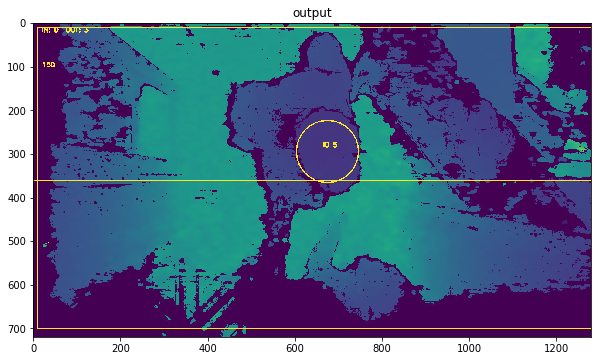

In [13]:
import os

#Instantiate the tracker
num_vid=0


# depthWriter = cv2.VideoWriter(depth_vid_direc+str(num_vid)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
# rgbWriter   = cv2.VideoWriter(rgb_vid_direc+str(num_vidcv2.IMREAD_GRAYSCALE)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
# finalWriter = cv2.VideoWriter(final_vid_direc+str(num_vid)+'.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1280,720))
depthWriter,rgbWriter,finalWriter = init_videoWriters(num_vid=num_vid)
num_frame = 0
obj_dummy_overhead = {'frame':-1,'x': 0 ,'y': 0 ,'r':0}
df_annotations = pd.DataFrame([obj_dummy_overhead])
isRecording = 0
recordStartTime = -1
BG = cv2.imread('depthData/bg.jpg',cv2.IMREAD_GRAYSCALE)
tracker = CentroidTracker(TRACKER_RETAIN_FRAMES,TRACKER_MAX_DIST_THESH,TRACKER_LINE_BOUNDARY)
for l in range (8,9):
    cap = cv2.VideoCapture('depthData/depth_4.avi')
    #cap = cv2.VideoCapture('depthData/depth_vids1/'+str(l)+'.avi')
    #tracker = CentroidTracker(4,50,250)
    direc = 'frames_vid_7'
    #os.mkdir(direc)
    k=0
    duration=0
    while(cap.isOpened()):
        ret, framex = cap.read()
        if ret<=0:
            break
        
        frame = np.copy(framex)
        #num_frame += 1
        k+=1
        #cv2.imwrite(direc+"/"+str(k)+".jpg",frame)
        #continue
        if recordStartTime > 0 and (time.time()- recordStartTime > 5):
            isRecording = 0
    
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        maskBG = np.abs(frame-BG)
        
        maskBG[maskBG<10]=0
        maskBG[maskBG>=10]=1
        
        mask = np.zeros((720,1280),'uint8')
        mask[ROI_STARTX:ROI_ENDX,ROI_STARTY:ROI_ENDY]=1
        
        #gray =gray[ROI_STARTX:ROI_ENDX,ROI_STARTY:ROI_ENDY]
        gray = np.copy(frame)*mask*maskBG
        cv2.rectangle(frame,(ROI_STARTY,ROI_STARTX),(ROI_ENDY,ROI_ENDX),(255,255,255),2)
        final = findHead(255-gray)

        #Get all Contours
        cnts = cv2.findContours(final.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        #Preprocess the contours
        circles= preprocess(cnts)

#       # Display output
        objects,radius = tracker.update(circles)
        
        
        if objects is not None :
            if((len(objects.items()) > 0) and isRecording ==0 ):
                recordStartTime = time.time()
                isRecording = 1
            
        #print (objects)
        # loop over the tracked objects
        
        for (objectID, centroid) in objects.items():
            # draw both the ID of the object and the centroid of the
            # object on the output frame
            text = "ID {}".format(objectID)
            cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.circle(frame, (centroid[0], centroid[1]), radius[objectID], (255, 255, 255), 2)
            obj_overhead = {'frame':num_frame,'x': centroid[0] ,'y': centroid[1],'r':100}
            df_annotations = df_annotations.append([obj_overhead])
            
        #Draw counter info
        counter_text = 'IN: '+str(tracker.personIn)+ "  OUT: " +str(tracker.personOut)
        cv2.putText(frame, counter_text, (20,20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(frame, str(k), (20,100),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.line(frame, (0,TRACKER_LINE_BOUNDARY), (1280,TRACKER_LINE_BOUNDARY), (255, 255, 255), 2)
        
        
        #Plot Image
        displayx(frame,"output",1)
        clear_output(wait=True)
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        if isRecording == 1:
            num_frame += 1
            depthWriter.write(framex)
            rgbWriter.write(framex)
            finalWriter.write(frame)
            
        if( num_frame> 0 and num_frame%150 == 0):
            df_annotations.to_csv('depth_final_annotations/depth_annotations_'+str(num_vid)+'.csv')
            num_vid += 1
            depthWriter,rgbWriter,finalWriter = init_videoWriters(num_vid = num_vid)
            
        

In [47]:
depthWriter.release()

In [ ]:
overlap(x,y,r,circles)

In [46]:
num_frame

330

In [45]:
df_annotations

,frame,x,y,w,h
0,156,513,-62,200,200
0,157,525,-52,200,200
0,158,535,-38,200,200
0,159,544,-24,200,200
0,160,556,-1,200,200
...,...,...,...,...,...
0,328,467,-31,200,200
0,329,532,544,200,200
0,329,475,-20,200,200
0,330,532,544,200,200


In [253]:
for circle in circles:
    #if (circle.x - x)*(circle.x - x) + (circle.y - y)*(circle.y - y) < (circle.r+r)*(circle.r+r):
    print(circle)

{'x': 421.62872314453125, 'y': 102, 'r': 64.31407928466797}


In [21]:
cap = cv2.VideoCapture('depthData/depth_vids1/14.avi')
ret, frame = cap.read()

In [16]:
frame = cv2.imread(direc+"/23.jpg")

In [17]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = gray[ROI_STARTX:ROI_ENDX,ROI_STARTY:ROI_ENDY]


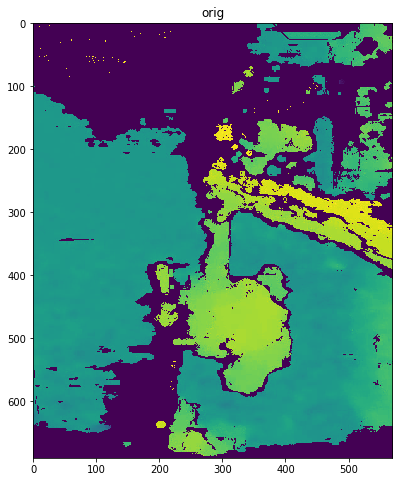

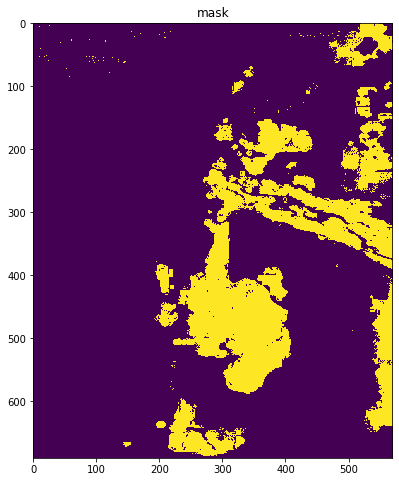

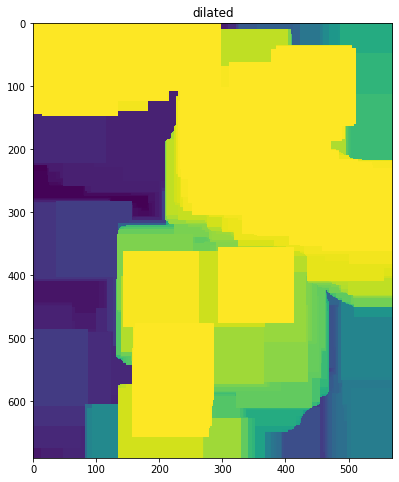

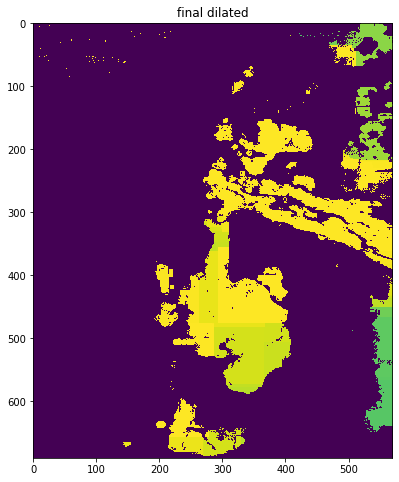

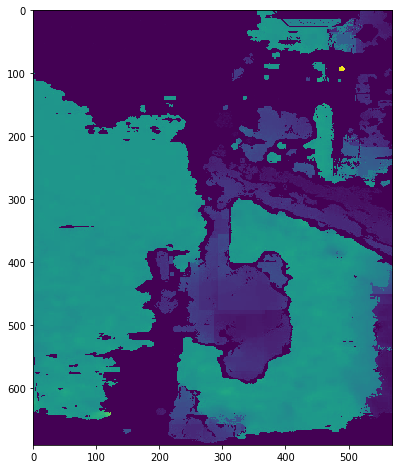

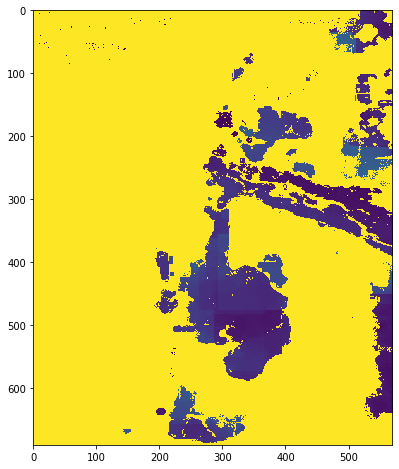

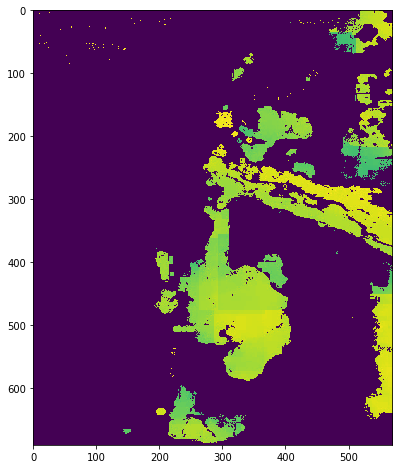

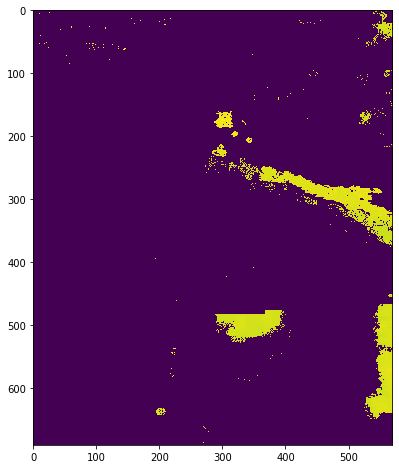

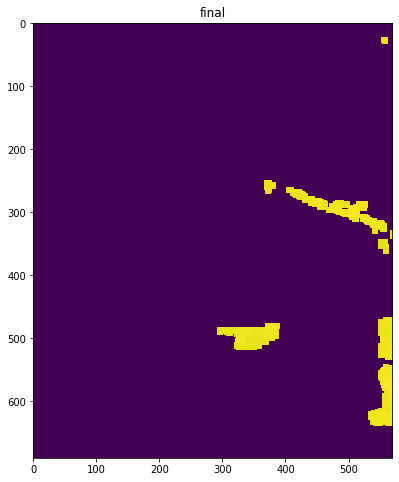

In [18]:
out = findHead(255-gray,show=1)

In [23]:
cnts = cv2.findContours(out.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

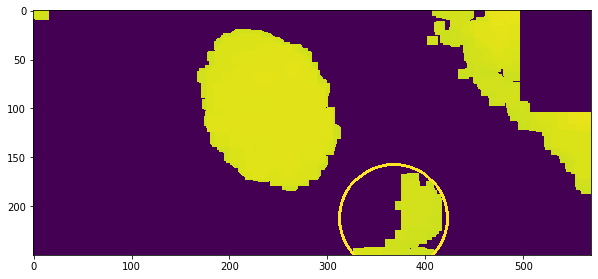

r 55.23194122314453
area 3339.5
w/h 1.0833333333333333
circle_area 9587.497326870232
ratio 0.3483182196714265


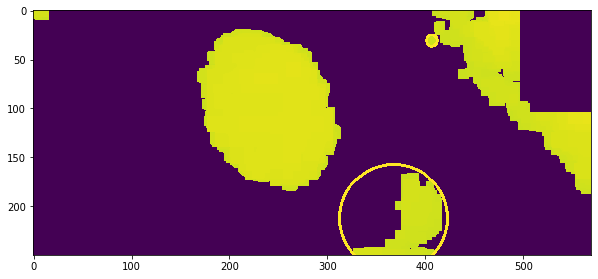

r 6.800835609436035
area 88.0
w/h 1.3333333333333333
circle_area 145.36143281494438
ratio 0.6053875384678573


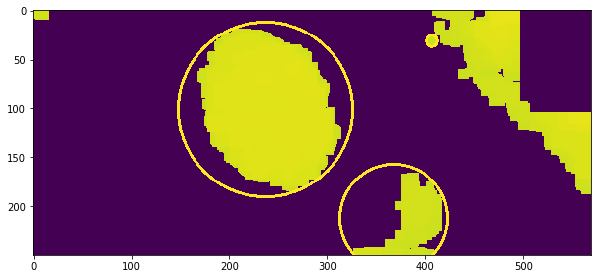

r 89.30995178222656
area 17336.0
w/h 0.8855421686746988
circle_area 25068.269245937132
ratio 0.6915515319355238


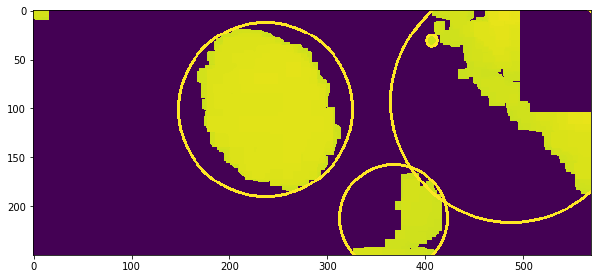

r 123.37959289550781
area 9311.5
w/h 0.8617021276595744
circle_area 47842.2181067639
ratio 0.1946293539154186


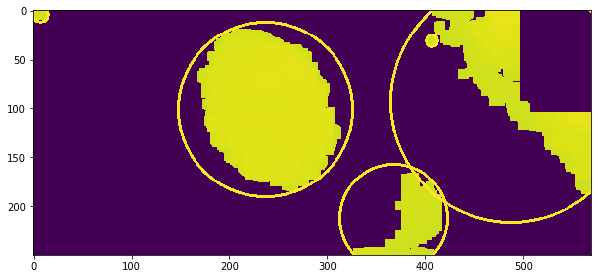

r 8.746527671813965
area 133.5
w/h 1.6
circle_area 240.43405984339475
ratio 0.5552457920768563


In [24]:
for cnt in cnts:
    area = cv2.contourArea(cnt)
    ((x,y),r)= cv2.minEnclosingCircle(cnt)
    area_circle = 22/7*r*r
    cv2.circle(out, (int(x),int(y)), int(r), (255, 255, 255), 2)
    displayx(out,"",1)
    x,y,w,h = cv2.boundingRect(cnt)
    
    print("r",r)
    print("area",area)
    print("w/h",w/h)
    print("circle_area",area_circle)
    print("ratio",area/area_circle)


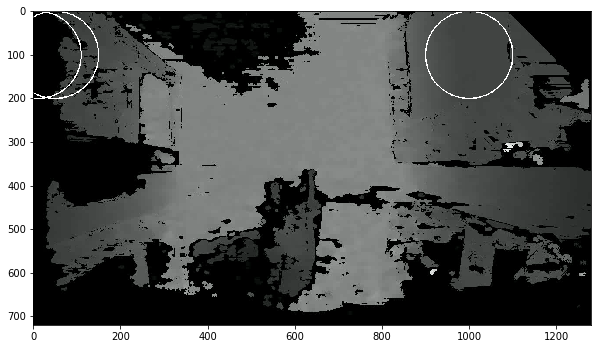

In [17]:
plt.figure(figsize=(10, 8))

cv2.circle(frame, (1000, 100), 100, (255, 255, 255), 2)
plt.imshow(frame)

(array([2.79433e+05, 1.03540e+04, 4.61400e+03, 6.13500e+03, 2.28700e+03,
        8.95000e+02, 8.62000e+02, 8.68000e+02, 2.98000e+02, 3.74000e+02,
        3.68000e+02, 4.68000e+02, 4.06000e+02, 6.62000e+02, 9.90000e+02,
        2.00000e+03, 3.33900e+03, 1.40410e+04, 1.46000e+03, 1.54570e+04,
        1.53620e+04, 1.61200e+03, 1.27840e+04, 2.68790e+04, 2.10900e+03,
        2.26460e+04, 1.27550e+04, 2.06360e+04, 2.39510e+04, 3.27960e+04,
        3.81110e+04, 2.19730e+04, 1.26640e+04, 8.29100e+03, 1.30600e+04,
        7.74300e+03, 5.92500e+03, 4.59200e+03, 9.44300e+03, 7.40800e+03,
        5.32600e+03, 6.22200e+03, 9.52400e+03, 3.23000e+03, 3.38100e+03,
        6.87000e+03, 4.04600e+03, 3.01000e+03, 6.43200e+03, 8.57000e+02,
        4.88000e+03, 5.20600e+03, 1.18700e+03, 5.22200e+03, 1.17490e+04,
        2.55300e+03, 2.81530e+04, 8.19360e+04, 3.65400e+03, 5.67340e+04,
        1.30220e+04, 7.63100e+03, 2.06900e+03, 7.64000e+02, 5.60000e+02,
        3.54000e+02, 1.80000e+02, 1.71000e+02, 1.42

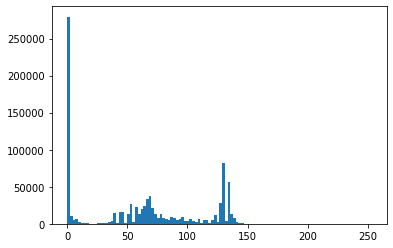

In [11]:
plt.hist(gray.ravel(),bins='auto')

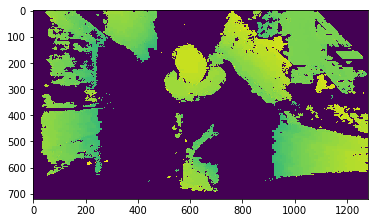

In [28]:
img1 = np.copy(255-gray)
img2= np.copy(255-gray)
img1[img1<160]=0
img1[img1>235]=0
plt.imshow(img1)

(array([3.06568e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.40000e+01, 3.74000e+02,
        3.68000e+02, 4.38000e+02, 4.36000e+02, 6.62000e+02, 9.90000e+02,
        7.01000e+02, 4.63800e+03, 1.40410e+04, 1.46000e+03, 1.38850e+04,
        1.69340e+04, 1.61200e+03, 1.27840e+04, 9.14600e+03, 1.78610e+04,
        2.46270e+04, 1.27550e+04, 1.79640e+04, 1.45240e+04, 4.48950e+04,
        3.50480e+04, 1.52930e+04, 1.23140e+04, 1.83840e+04, 7.73900e+03,
        6.79800e+03, 1.21600e+04, 4.62300e+03, 6.04700e+03, 9.77500e+03,
        1.06000e+03, 1.15170e+04, 8.72200e+03, 8.27000e+02, 5.89400e+03,
        3.92800e+03, 4.39800e+03, 5.58600e+03, 3.38800e+03, 4.59100e+03,
        4.07100e+03, 2.77300e+03, 4.41800e+03, 2.68400e+03, 7.55900e+03,
        9.20400e+03, 1.13270e+04, 1.99950e+04, 8.24110e+04, 3.83630e+04,
        2.07610e+04, 1.72530e+04, 2.55500e+03, 1.02400e+03, 7.39000e+02,
        2.08000e+02, 4.56000e+02]),
 array([  0.   

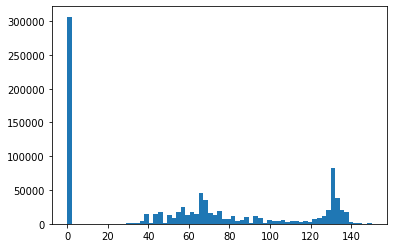

In [15]:
plt.hist(img1.ravel(),bins='auto')

In [26]:
a=[[0,5,9],[2,1,3],[9,6,1]]

In [27]:
a

[[0, 5, 9], [2, 1, 3], [9, 6, 1]]

In [29]:
D=np.random.rand(3,3)

In [30]:
D

array([[0.71352402, 0.38104966, 0.39014847],
       [0.21027852, 0.76080249, 0.10855579],
       [0.22617831, 0.00335371, 0.25499544]])

In [39]:
rows=D.min(axis=1).argsort()

In [41]:
D.argmin(axis=1)[rows]

array([1, 2, 1])

In [38]:
rows

array([2, 1, 0])

In [24]:
!mkdir depth_final_annotations